## Advanced ML: Домашнее задание 1
Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились. В качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему в этом ноутбуке категорически приветствуются. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data
1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).
2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.
* Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.
* Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).
* Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).
3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

![image info](./task.png)

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.
* Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.
* Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.
* Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?
4. Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?
5. [Эта часть задания не оценивается, здесь нет правильных и неправильных ответов, но буду рад узнать, что вы думаете]
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?

In [2]:
# Загрузка данных

import os
import requests

CSV_URL = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

with open(os.path.split(CSV_URL)[1], 'wb') as f, \
        requests.get(CSV_URL, stream=True) as r:
    for line in r.iter_lines():
        f.write(line+'\n'.encode())

In [3]:
import pandas as pd


data = pd.read_csv(os.path.split(CSV_URL)[1])
data = data[['continent', 'location', 'date', 'total_cases', 'new_cases']]
data.head()

,continent,location,date,total_cases,new_cases
0,Asia,Afghanistan,2020-02-24,5.0,5.0
1,Asia,Afghanistan,2020-02-25,5.0,0.0
2,Asia,Afghanistan,2020-02-26,5.0,0.0
3,Asia,Afghanistan,2020-02-27,5.0,0.0
4,Asia,Afghanistan,2020-02-28,5.0,0.0


<AxesSubplot:title={'center':'Daily number of cases SARS-COV-19 based on date in Russia'}, xlabel='date', ylabel='new cases'>

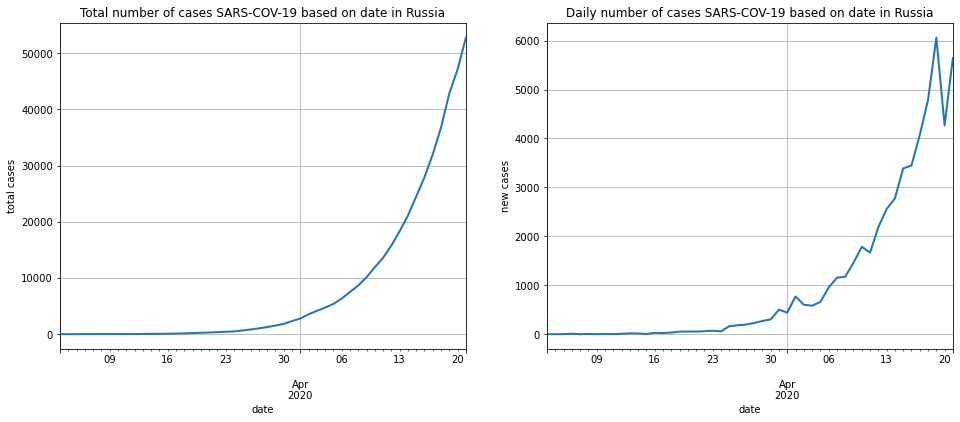

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline


rus_data = data[data.location == 'Russia']
rus_data = rus_data[rus_data.date >= '2020-03-03']
rus_data.date = pd.to_datetime(rus_data.date)
rus_data.index = rus_data.date
train_total_cases, test_total_cases, train_new_cases, test_new_cases = train_test_split(
    rus_data.total_cases, rus_data.new_cases, train_size=50, shuffle=False)
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
train_total_cases.plot(ax = ax, grid=True, ylabel='total cases', linewidth=2.0, title='Total number of cases SARS-COV-19 based on date in Russia')
ax = fig.add_subplot(122)
train_new_cases.plot(ax = ax, grid=True, ylabel='new cases', linewidth=2.0, title='Daily number of cases SARS-COV-19 based on date in Russia')

Для расчёта апостериорного распределения воспользуемся функцией Байесовского обновления параметров.
Для этого также подготовим матрицу признаков, а также проведём семплирование веса модели
Однако есть ещё один момент. Если мы будем просто предсказывать общее число случаев, где один из признаков будет экспонентой, то велика вероятность memory_overflow. Поэтому чтобы упростить решение задачи, прологарифмируем y, а потом будем искать подходящее апостериорное распределение
А в качестве признаков предлагается взять номер дня (для предсказания логарифма, но учитывая, что рост постепенно задерживается), то можно попробовать замедлить рост экспоненты путём взятия корней n_степени относительно номера дня.

In [436]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')


class LinearRegression:
    def __init__(self, n_features):
        self.mu = np.zeros(n_features)
        self.sigma = np.eye(n_features)

    def _bayesian_update(self, X, y, sigma_noise=.25):
        sigma_n = np.linalg.inv(np.linalg.inv(self.sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(X), X) )
        mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(self.sigma), np.transpose(self.mu)) +
                         (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(X), y))
        return mu_n, sigma_n

    def fit(self, X, y):
        self.mu, self.sigma = self._bayesian_update(X, y)

    def predict(self, X):
        return X.dot(self.mu)

    def bayes_sample_predict(self, X, n):
        my_w = np.random.multivariate_normal(self.mu, self.sigma, n)
        return [X.dot(w) for w in my_w]


def transform_into_train(series, train_days, n_features):
    target_col = series.name
    X = pd.DataFrame(series)
    day = np.arange(len(series))
    X['bias'] = 1
    for root in range(1, n_features + 1):
        X[f'day_root{root}'] = np.power(day, 1 / root)
    target = np.log(X[target_col])
    X_train, X_test, y_train, y_test = train_test_split(X.drop([target_col], axis=1), target, train_size=train_days, shuffle=False)
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = transform_into_train(rus_data.total_cases, 50, 7)
lr = LinearRegression(8)
lr.fit(X_train, y_train)
pred = np.exp(lr.predict(X_train))

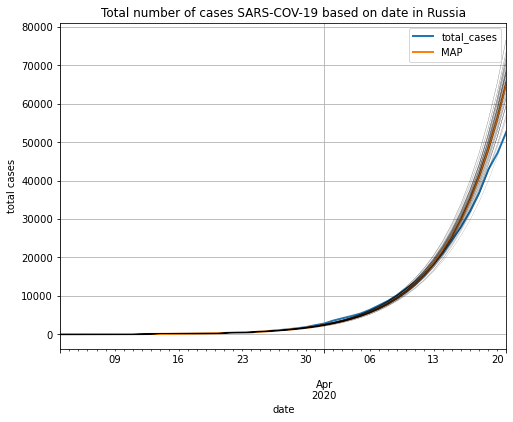

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
train_total_cases.plot(ax = ax, grid=True, ylabel='total cases', linewidth=2.0, title='Total number of cases SARS-COV-19 based on date in Russia')
pred.plot(ax = ax, grid=True, linewidth=2.0, label='MAP')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
lines = [np.exp(line) for line in lr.bayes_sample_predict(X_train, 50)]
for line in lines:
    line.plot(ax=ax, grid=True, linewidth=0.1, color='black')

Дисперсия шума:

In [8]:
np.std(y_train - lr.predict(X_train))

0.1674824079034385

Семплирование прямых:

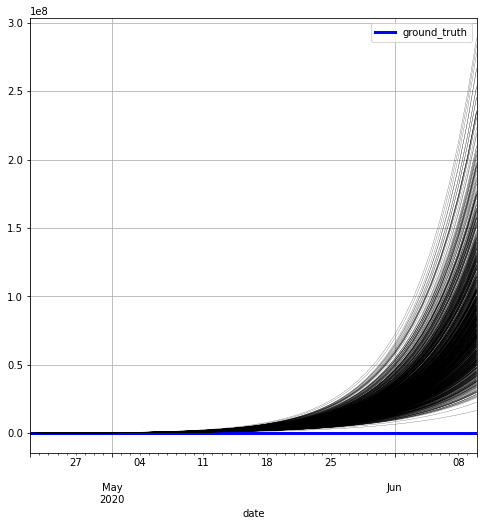

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
lines = [np.exp(line) for line in lr.bayes_sample_predict(X_test.iloc[:50], 100)]
y_test.iloc[:50].plot(ax=ax, grid=True, linewidth=3, color='blue', label='ground_truth')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
for line in lines:
    line.plot(ax=ax, grid=True, linewidth=0.2, color='black')

Из графика видно, что экспонента растёт ну уж слишком быстро. Посчитаем значения квантилей для предсказательного распределения. Для этого насмеплируем 1000 экспонент

In [10]:
important_dates = pd.to_datetime(['2020-05-01', '2020-06-01', '2020-09-01'])
X_test_cut = X_test[:important_dates[-1]]
lines = pd.concat([np.exp(line) for line in lr.bayes_sample_predict(X_test_cut, 1000)], axis=1)
for date in important_dates:
    print(f'''
    Благоприятный прогноз на {date.date()}: {round(lines.quantile(0.1, axis=1)[date])}
    Мат ожидание прогноза на {date.date()}: {round(lines.mean(axis=1)[date])}
    Негативный прогноз на {date.date()}: {round(lines.quantile(0.9, axis=1)[date])}''')


    Благоприятный прогноз на 2020-05-01: 252375
    Мат ожидание прогноза на 2020-05-01: 306093
    Негативный прогноз на 2020-05-01: 366212

    Благоприятный прогноз на 2020-06-01: 15033804
    Мат ожидание прогноза на 2020-06-01: 26403122
    Негативный прогноз на 2020-06-01: 40431013

    Благоприятный прогноз на 2020-09-01: 470490767894
    Мат ожидание прогноза на 2020-09-01: 6073573172691
    Негативный прогноз на 2020-09-01: 13361294333056


### Часть 3.
Внесём константу под интеграл. Внутри интеграла квадратичная от t, где t - номер дня. А интеграл - это сумма по всем дням. По факту эта модель говорит нам, что можно взять число ежедневных случаев и проинтегрировать по номеру дня. Соотвественно, теперь можно отбросить интеграл и перейти к предсказанию числа ежедневных случаев, а потом взять кумулятивную сумму. Т.е. по факту мы говорим, что есть какой-то день x, когда был резкий всплеск заболеваний, так называемая волна. Причём эти волны часто связаны со штаммами. И наверное можно получить, что каждая волна и является такой гауссианой. Чуть ниже я проведу небольшой эксперимент с суммой гауссиан и актуальными данными на сегодня.

In [11]:
def transform_day_into_train(series, train_days, n_features):
    target_col = series.name
    X = pd.DataFrame(series)
    day = np.arange(len(series))
    X['bias'] = 1
    for power in range(1, n_features + 1):
        X[f'day_power{power}'] = np.power(day, power)
    target = X[target_col]
    target[target == 0] = 1
    target = np.log(target)
    X_train, X_test, y_train, y_test = train_test_split(X.drop([target_col], axis=1), target, train_size=train_days, shuffle=False)
    return X_train, X_test, y_train, y_test

In [12]:
n_features = 2
X_train, X_test, y_train, y_test = transform_day_into_train(rus_data.new_cases, 50, n_features)
lr = LinearRegression(n_features + 1)
lr.fit(X_train, y_train)
pred = np.exp(lr.predict(X_train)).cumsum()

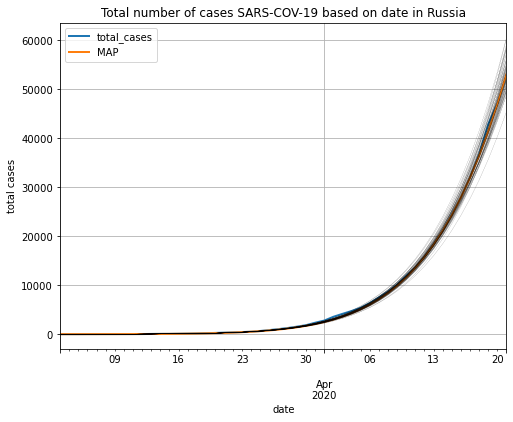

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
train_total_cases.plot(ax = ax, grid=True, ylabel='total cases', linewidth=2.0, title='Total number of cases SARS-COV-19 based on date in Russia')
pred.plot(ax = ax, grid=True, linewidth=2.0, label='MAP')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
lines = [np.exp(line).cumsum() for line in lr.bayes_sample_predict(X_train, 50)]
for line in lines:
    line.plot(ax=ax, grid=True, linewidth=0.1, color='black')

In [14]:
print('Дисперсия шума:', np.std(y_train - lr.predict(X_train)))

Дисперсия шума: 0.48917158143501466


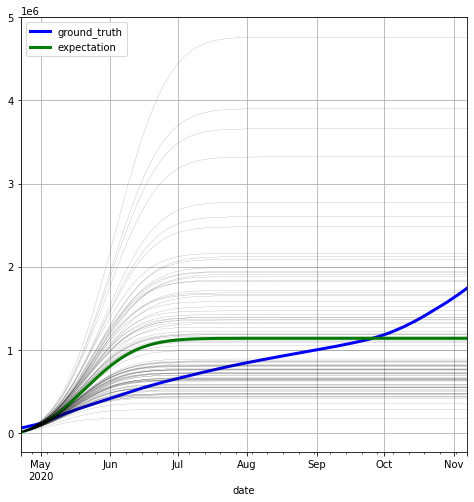

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
lines = [np.exp(line).cumsum() for line in lr.bayes_sample_predict(X_test.iloc[:200], 100)]
expectation = pd.concat(lines, axis=1).mean(axis=1)
test_total_cases.iloc[:200].plot(ax=ax, grid=True, linewidth=3, color='blue', label='ground_truth')
expectation.plot(ax=ax, grid=True, linewidth=3, color='green', label='expectation')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
for line in lines:
    line.plot(ax=ax, grid=True, linewidth=0.1, color='black')

In [16]:
important_dates = pd.to_datetime(['2020-05-01', '2020-06-01', '2020-09-01'])
X_test_cut = X_test[:important_dates[-1]]
lines = pd.concat([np.exp(line).cumsum() for line in lr.bayes_sample_predict(X_test_cut, 1000)], axis=1)
for date in important_dates:
    print(f'''
    Благоприятный прогноз на {date.date()}: {round(lines.quantile(0.1, axis=1)[date])}
    Мат ожидание прогноза на {date.date()}: {round(lines.mean(axis=1)[date])}
    Негативный прогноз на {date.date()}: {round(lines.quantile(0.9, axis=1)[date])}''')


    Благоприятный прогноз на 2020-05-01: 80432
    Мат ожидание прогноза на 2020-05-01: 100153
    Негативный прогноз на 2020-05-01: 122210

    Благоприятный прогноз на 2020-06-01: 395460
    Мат ожидание прогноза на 2020-06-01: 759044
    Негативный прогноз на 2020-06-01: 1222377

    Благоприятный прогноз на 2020-09-01: 437267
    Мат ожидание прогноза на 2020-09-01: 1042275
    Негативный прогноз на 2020-09-01: 1840824


Тут видно, что пандемия гораздо дольше затихала, нежели мы предполгали, Получается, что там не Гауссиана, а другое распределение с длинным хвостом.
В качестве такого распределения можно взять Гамма, тем более оно входит в семейство экспоненциальных распределений, для которых можно применять обобщённые линейные модели.

Ладно, начнём с суммы гауссиан.

<AxesSubplot:xlabel='date'>

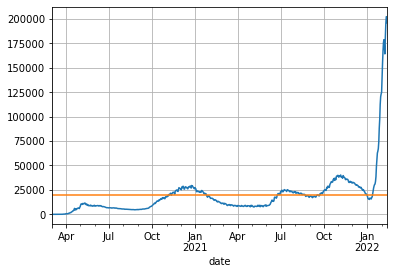

In [38]:
rus_data.new_cases.plot()
pd.Series(20000 * np.ones_like(rus_data.new_cases.values), index=rus_data.index).plot(grid=True)

По рисунку видно, что мы тут сумма 5 гауссиан. Итак, если вспомнить, как мы решали прошлую задачу, то там был интеграл по времени, в случае такой модели будет сумма интегралов, что является интегралом суммы и мы опять можем смело работать с дневными данными, однако на этот раз так просто взять логарифм целевой переменной мы уже не можем, т.к. у нас сумма экспонент. Осталось понять как выбрать центры этих самых гауссиан.

Идея из разряда эвсристики - посмотреть на точки перегиба, они являются началом волны, тогда концом волны можно смело назвать следующую точку перегиба.
Таким образом можно последовательно обучать гауссиану на своём датасете, а потом вычитать её значения из целевой переменной.

Итак, если говорить об эвристике, то нас интересуют, пожалуй даже не точки перегиба, а минимумы функции. Можно взять аналог производной - первые разности. Хотя красивую картинку я скорее всего не ожидаю. Из-за сезонности будет большое число локальных минимумов. Поэтому проще будет его найти путём семплирования горизонтальных прямых. Для каждой такой прямой будем рассматривать множество точек ниже. Если для какой-то из таких точек в достаточно большой её окрестности не будет других - это искомый минимум. Чтобы посчитать окрестность можно взять соседей справа и слева

In [56]:
lines = np.random.uniform(0, 20000, 10000)
minimums = set()
for line in lines:
    low_data = rus_data.new_cases[rus_data.new_cases < line].reset_index()
    low_data['previous_date'] = (low_data.date - low_data.date.shift(1)).map(lambda x: x.days).fillna(31)
    low_data['next_date'] = (low_data.date.shift(-1) - low_data.date).map(lambda x: x.days).fillna(31)
    minimum = low_data[(low_data.previous_date > 30) & (low_data.next_date > 30)].date.tolist()
    if len(minimum) > 0:
        minimums.add(*minimum)
print(minimums)

{Timestamp('2021-09-07 00:00:00'), Timestamp('2021-05-06 00:00:00'), Timestamp('2022-01-06 00:00:00'), Timestamp('2020-08-25 00:00:00')}


Значения в точках минимума похожи на правду. Попробуем построить области, внутри которых мы будем обучать модели

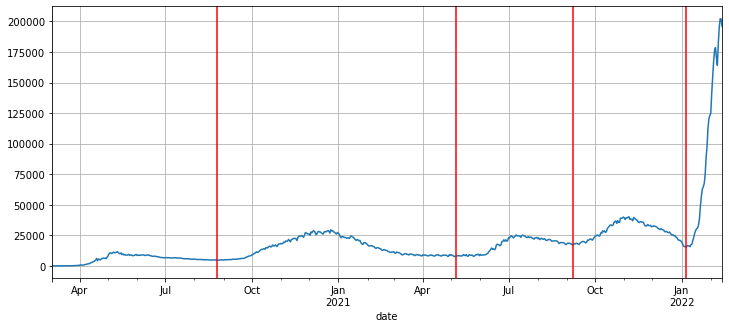

In [68]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
rus_data.new_cases.plot(grid=True)
for v_line in list(minimums):
    plt.axvline(x=v_line, color='r')

Попробуем построить первую модельку и посмотреть будет ли вообще работать такая идея

In [424]:
def prepare_df(data, minimums, daily_pred, max_test_day, n_features=2, iter=0, log=True):
    for _, pred in daily_pred.items():
        data = data - pred

    if iter == 0:
        left_bound = data.index[0]
    else:
        left_bound = minimums[iter - 1]
    if iter < len(minimums):
        right_bound = minimums[iter]
    else:
        right_bound = max_test_day
    train_days = (right_bound - left_bound).days

    data = data.loc[left_bound:]
    X = pd.DataFrame(data)
    day = np.arange(len(data))
    X['bias'] = 1
    for power in range(1, n_features + 1):
        X[f'day_power{power}'] = np.power(day, power)
    target = X.new_cases
    target[target == 0] = 1
    if log:
        target = np.log(target)
    X = X.drop(['new_cases'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X.loc[:max_test_day], target.loc[:max_test_day], train_size=train_days, shuffle=False)
    return X, X_train, X_test, y_train, y_test

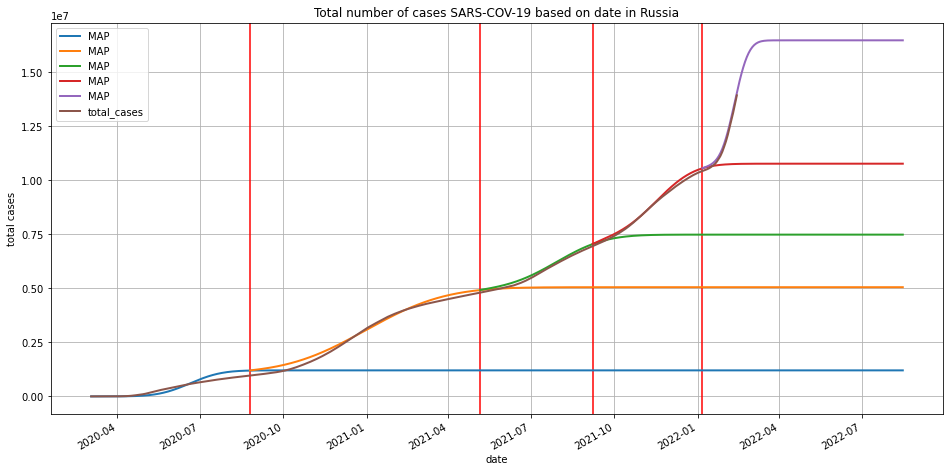

In [359]:
from datetime import timedelta

y = rus_data.new_cases
max_test_day = y.index[-1]
future_index = y[-183:].index.map(lambda x: x + timedelta(183))
future = pd.Series(np.zeros(183), index=future_index, name='new_cases')
y = y.append(future)

pred, daily_pred = pd.Series(np.zeros(len(y)), index=y.index, name='new_cases'), {}
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
for v_line in list(minimums):
    plt.axvline(x=v_line, color='r')
for iter in range(len(minimums) + 1):
    X, X_train, X_test, y_train, y_test = prepare_df(y, minimums, daily_pred, max_test_day, iter=iter)
    lr = LinearRegression(3)
    lr.fit(X_train, y_train)
    daily_pred[iter] = pd.Series(np.exp(lr.predict(X)), index=X.index, name='new_cases')
    pred = pred + daily_pred[iter].cumsum()
    pred.plot(ax = ax, grid=True, linewidth=2.0, label='MAP')

rus_data.total_cases.plot(ax = ax, grid=True, ylabel='total cases', linewidth=2.0, title='Total number of cases SARS-COV-19 based on date in Russia')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

Теперь перейдём к прогнозам. Модели строятся последовательно, т.е. результат каждой следующей зависит от прогноза предыдущей. Как теперь получить доверительные интервалы? Можно попробовать также семплировать доверительные интервалы. Как именно? Обучаем модельку, семплируем 1 интервал, потом для следующей и т.д.

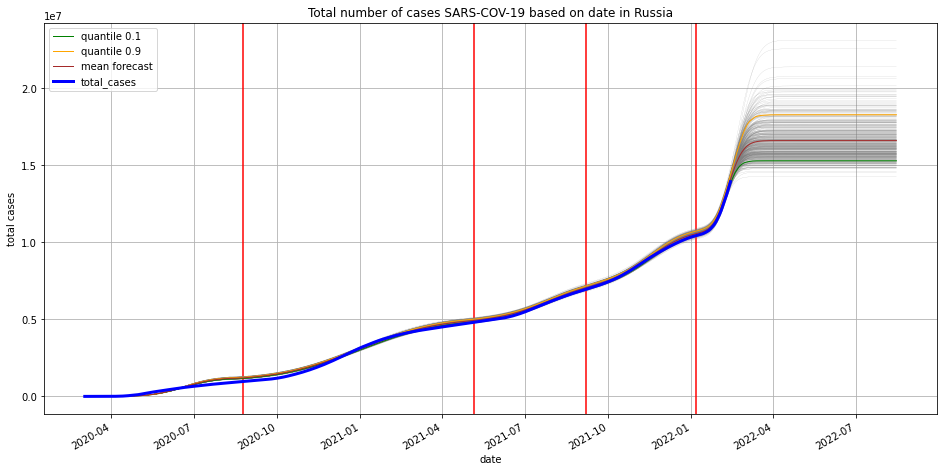

In [376]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
for v_line in list(minimums):
    plt.axvline(x=v_line, color='r')

preds = []
for _ in range(500):
    pred, daily_pred = pd.Series(np.zeros(len(y)), index=y.index, name='new_cases'), {}
    for iter in range(len(minimums) + 1):
        X, X_train, X_test, y_train, y_test = prepare_df(y, minimums, daily_pred, max_test_day, iter=iter)
        lr = LinearRegression(3)
        lr.fit(X_train, y_train)
        daily_pred[iter] = pd.Series(np.exp(lr.bayes_sample_predict(X, 1)[0]), index=X.index, name='new_cases')
        pred[daily_pred[iter].index] = pred + daily_pred[iter].cumsum()
    pred.plot(ax=ax, grid=True, linewidth=0.1, color='grey')
    preds.append(pred)

lines = pd.concat(preds, axis=1)
lines.quantile(0.1, axis=1).plot(ax = ax, linewidth=1.0, color='g', label='quantile 0.1')
lines.quantile(0.9, axis=1).plot(ax = ax, linewidth=1.0, color='orange', label='quantile 0.9')
lines.mean(axis=1).plot(ax = ax, linewidth=1.0, color='brown', label='mean forecast')
rus_data.total_cases.plot(ax = ax, grid=True, ylabel='total cases', linewidth=3.0, color='b', title='Total number of cases SARS-COV-19 based on date in Russia')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-4:], labels[-4:])

А теперь можно посчитать квантили(1 неделя, 1 месяц, 2 месяца и 6 месяцев)


In [377]:
important_dates = [
    max_test_day + timedelta(days=1),
    max_test_day + timedelta(days=7),
    max_test_day + pd.DateOffset(months=1),
    max_test_day + pd.DateOffset(months=2),
    max_test_day + pd.DateOffset(months=6)
]
for date in important_dates:
    print(f'''
    Благоприятный прогноз на {date.date()}: {round(lines.quantile(0.1, axis=1)[date])}
    Мат ожидание прогноза на {date.date()}: {round(lines.mean(axis=1)[date])}
    Негативный прогноз на {date.date()}: {round(lines.quantile(0.9, axis=1)[date])}''')


    Благоприятный прогноз на 2022-02-14: 13943369
    Мат ожидание прогноза на 2022-02-14: 14237423
    Негативный прогноз на 2022-02-14: 14577895

    Благоприятный прогноз на 2022-02-20: 14688899
    Мат ожидание прогноза на 2022-02-20: 15200221
    Негативный прогноз на 2022-02-20: 15806696

    Благоприятный прогноз на 2022-03-13: 15273184
    Мат ожидание прогноза на 2022-03-13: 16509959
    Негативный прогноз на 2022-03-13: 18138954

    Благоприятный прогноз на 2022-04-13: 15280042
    Мат ожидание прогноза на 2022-04-13: 16586244
    Негативный прогноз на 2022-04-13: 18262903

    Благоприятный прогноз на 2022-08-13: 15280053
    Мат ожидание прогноза на 2022-08-13: 16586353
    Негативный прогноз на 2022-08-13: 18263052


Судя по результатам, то можно ожидать скорого конца этой волны. Из интересных особенностей - весь код работает для произвольного числа волн. Можно сделать даже небольшой сервис.
А ещё можно применить тот же код и для других стран, соберём весь код и построим график для США

In [783]:
class LinearRegression:
    def __init__(self, n_features):
        self.mu = np.zeros(n_features)
        self.sigma = np.eye(n_features)

    def _bayesian_update(self, X, y, sigma_noise=.25):
        sigma_n = np.linalg.inv(np.linalg.inv(self.sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(X), X) )
        mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(self.sigma), np.transpose(self.mu)) +
                         (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(X), y))
        return mu_n, sigma_n

    def fit(self, X, y):
        self.mu, self.sigma = self._bayesian_update(X, y)

    def predict(self, X):
        return X.dot(self.mu)

    def bayes_sample_predict(self, X, n):
        my_w = np.random.multivariate_normal(self.mu, self.sigma, n)
        return [X.dot(w) for w in my_w]


def prepare_df(data, minimums, daily_pred, max_test_day, n_features=2, iter=0, log=True):
    for _, pred in daily_pred.items():
        data = data - pred

    if iter == 0:
        left_bound = data.index[0]
    else:
        left_bound = minimums[iter - 1]
    if iter < len(minimums):
        right_bound = minimums[iter]
    else:
        right_bound = max_test_day
    train_days = (right_bound - left_bound).days

    data = data.loc[left_bound:]
    X = pd.DataFrame(data)
    day = np.arange(len(data))
    X['bias'] = 1
    for power in range(1, n_features + 1):
        X[f'day_power{power}'] = np.power(day, power)
    target = X.new_cases
    target[target <= 1] = 1
    if log:
        target = np.log(target)
    X = X.drop(['new_cases'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=train_days, shuffle=False)
    return X, X_train, X_test, y_train, y_test


def make_plots(country):
    # get series
    data = pd.read_csv(os.path.split(CSV_URL)[1])
    country_data = data[data.location == country]
    country_data = country_data[country_data.total_cases >= 5]
    country_data.date = pd.to_datetime(country_data.date)
    country_data.index = country_data.date
    y = country_data.new_cases.dropna()
    max_test_day = y.index[-1]
    # find minimums
    smoothed_y = y.shift(-5).rolling(10).mean().dropna().astype(int)
    lines = smoothed_y.unique()
    minimums = set()
    for line in lines:
        low_data = smoothed_y[smoothed_y <= line].reset_index()
        low_data['previous_date'] = (low_data.date - low_data.date.shift(1)).map(lambda x: x.days).fillna(61)
        low_data['next_date'] = (low_data.date.shift(-1) - low_data.date).map(lambda x: x.days).fillna(61)
        minimum = low_data[(low_data.previous_date > 60) & (low_data.next_date > 60)].date.tolist()
        if len(minimum) > 0:
            for m in minimum:
                minimums.add(m)
    minimums = sorted(list(minimums))
    minimums = [m for m in minimums if m < max_test_day - timedelta(days=31)]
    minimums = [m for m in minimums if m > y.index[0] + timedelta(days=61)]
    # plot # 1
    future_index = [y.index[-1] + timedelta(days=(x + 1)) for x in range(91)]
    future = pd.Series(np.zeros(91), index=future_index, name='new_cases')
    y = y.append(future)
    pred, daily_pred = pd.Series(np.zeros(len(y)), index=y.index, name='new_cases'), {}
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    for v_line in minimums:
        plt.axvline(x=v_line, color='r')
    for iter in range(len(minimums) + 1):
        X, X_train, X_test, y_train, y_test = prepare_df(y, minimums, daily_pred, max_test_day, iter=iter)
        lr = LinearRegression(3)
        lr.fit(X_train, y_train)
        tmp = lr.predict(X)
        daily_pred[iter] = pd.Series(np.exp(tmp), index=X.index, name='new_cases')
        pred = pred + daily_pred[iter].cumsum()
        bias = country_data.total_cases[X_train.index[0]] - pred[X_train.index[0]]
        pred[X_train.index[0]:] += bias
        pred.plot(ax = ax, grid=True, linewidth=2.0, label=f'MAP of {iter} model')
    country_data.total_cases.plot(ax = ax, grid=True, ylabel='total cases', linewidth=2.0, title=f'Total number of cases SARS-COV-19 based on date in {country}')
    handles, labels = ax.get_legend_handles_labels()
    plt.ylim([0, 2 * country_data.total_cases.max()])
    ax.legend(handles, labels)
    # figure 2
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    for v_line in list(minimums):
        plt.axvline(x=v_line, color='r')
    preds = []
    for _ in range(500):
        pred, daily_pred = pd.Series(np.zeros(len(y)), index=y.index, name='new_cases'), {}
        for iter in range(len(minimums) + 1):
            X, X_train, X_test, y_train, y_test = prepare_df(y, minimums, daily_pred, max_test_day, iter=iter)
            lr = LinearRegression(3)
            lr.fit(X_train, y_train)
            daily_pred[iter] = pd.Series(np.exp(lr.bayes_sample_predict(X, 1)[0]), index=X.index, name='new_cases')
            pred.loc[daily_pred[iter].index] += daily_pred[iter].cumsum()
            bias = country_data.total_cases[X_train.index[0]] - pred[X_train.index[0]]
            pred[X_train.index[0]:] += bias
        pred.plot(ax=ax, grid=True, linewidth=0.1, color='grey')
        preds.append(pred)
    lines = pd.concat(preds, axis=1)

    def limited_mean(s):
        low = s.quantile(0.1)
        up = s.quantile(0.9)
        s = s[s >= low]
        s = s[s <= up]
        return s.mean()

    lines.quantile(0.1, axis=1).plot(ax = ax, linewidth=1.0, color='g', label='quantile 0.1')
    lines.quantile(0.9, axis=1).plot(ax = ax, linewidth=1.0, color='orange', label='quantile 0.9')
    lines.apply(limited_mean, axis=1).plot(ax = ax, linewidth=1.0, color='brown', label='mean forecast')
    country_data.total_cases.plot(ax = ax, grid=True, ylabel='total cases', linewidth=3.0, color='b', title=f'Total number of cases SARS-COV-19 based on date in {country}')
    handles, labels = ax.get_legend_handles_labels()
    plt.ylim([0, 2 * country_data.total_cases.max()])
    ax.legend(handles[-4:], labels[-4:])

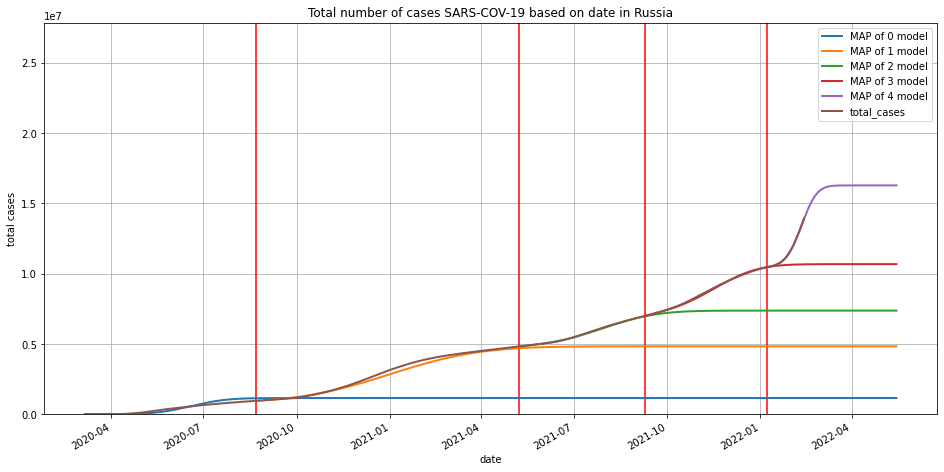

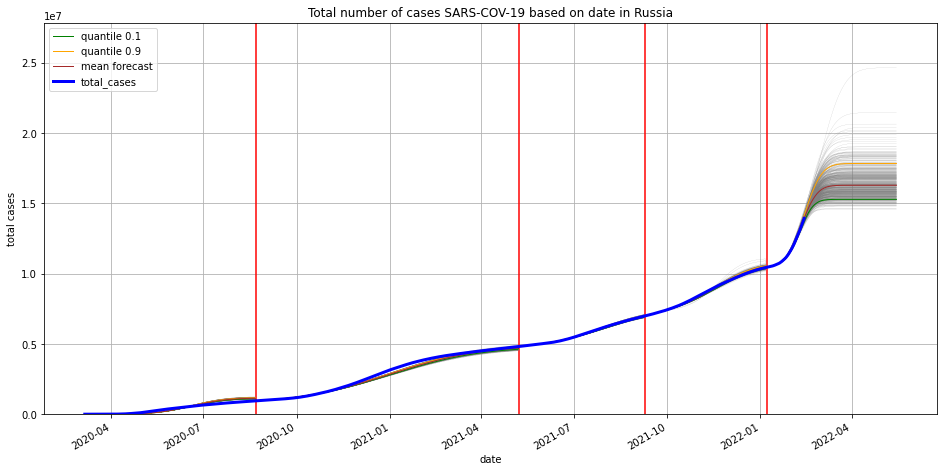

In [784]:
make_plots('Russia')

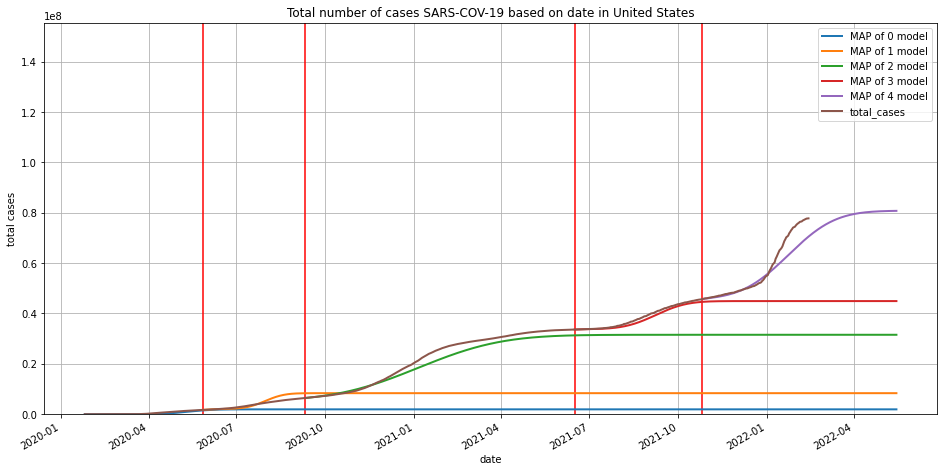

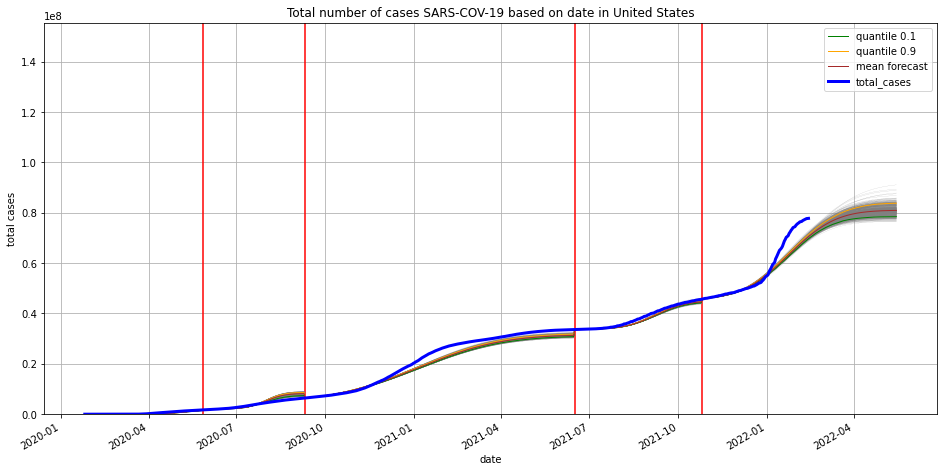

In [785]:
make_plots('United States')

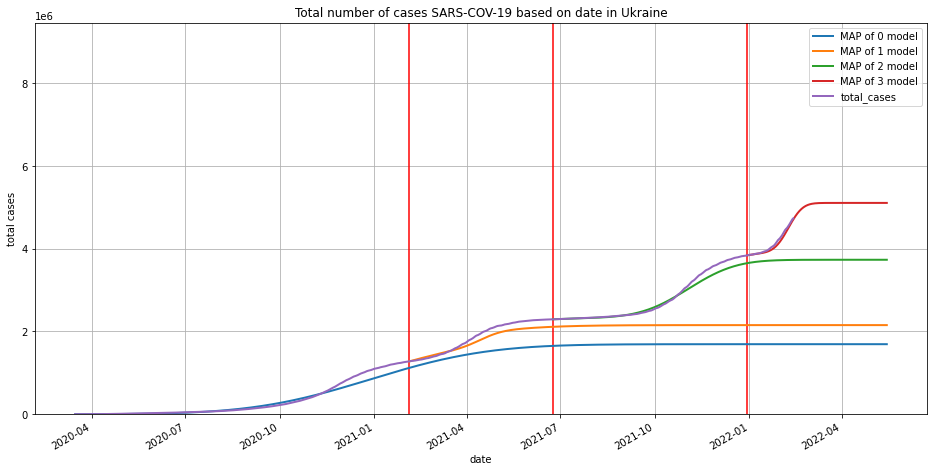

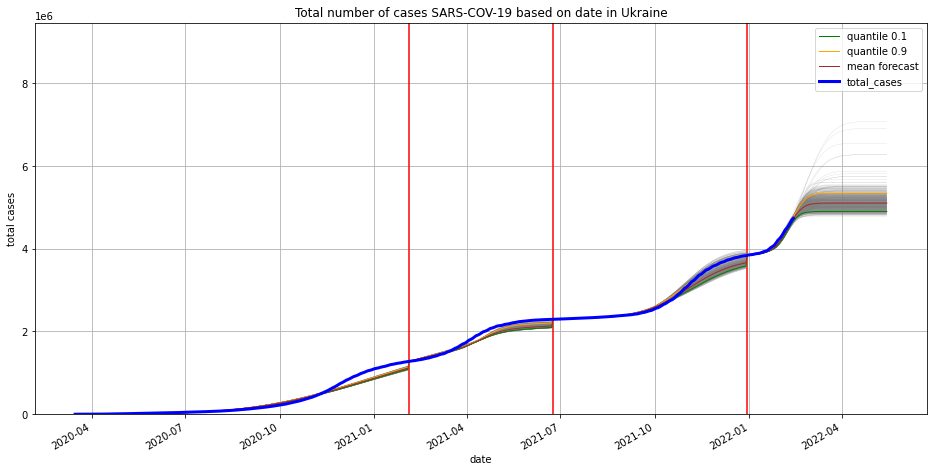

In [786]:
make_plots('Ukraine')

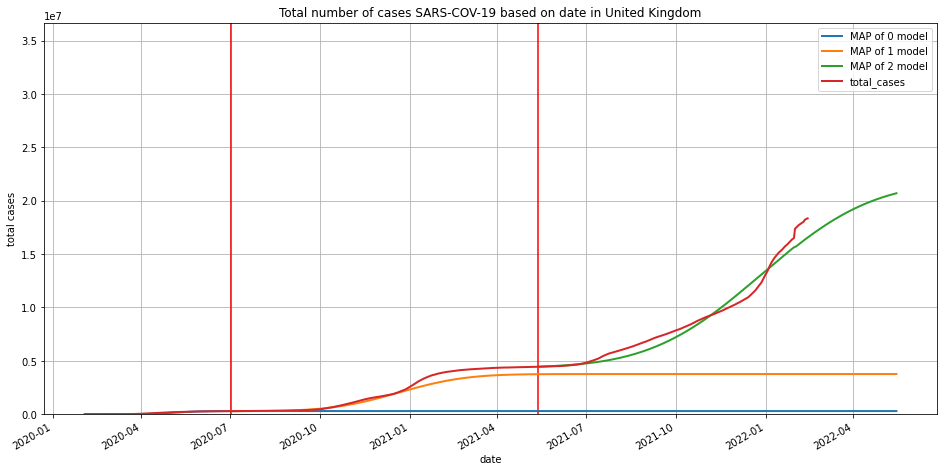

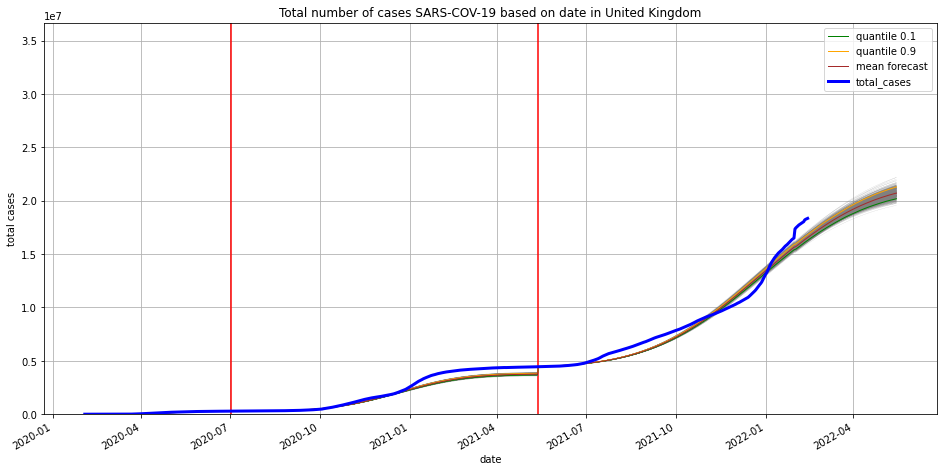

In [787]:
make_plots('United Kingdom')

Из этого исследования видно, что какие-то страны хорошо объясняются, какие-то хуже. Модель является эврестической. Надеюсь, что по мере изучения курса получится найти более разумные подходы.
В частности, когда я сдвигал данные, то на самом деле мне нужно было выбрать какую-то из гипотез, которая проходит, через нужную точку?...
А ещё очень многие проблемы берётся из-за неправильного выбора начала волны.